# ECG Anomaly Detection

## Introduction

In [67]:
# Imports
import torch
import tensorflow as tf

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from arff2pandas import a2p


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='darkgrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### The Dataset

From [timeseriesclassification.com...](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000) The original dataset for "ECG5000" is a 20-hour long ECG downloaded from Physionet. The name is BIDMC Congestive Heart Failure Database(chfdb) and it is record "chf07". It was originally published in "Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23)". The data was pre-processed in two steps: (1) extract each heartbeat, (2) make each heartbeat equal length using interpolation. This dataset was originally used in paper "A general framework for never-ending learning from time series streams", DAMI 29(6). After that, 5,000 heartbeats were randomly selected. The patient has severe congestive heart failure and the class values were obtained by automated annotation.

In [23]:
# Load the data

with open('data/ECG5000_TRAIN.arff') as f:
    train = a2p.load(f)
    
with open('data/ECG5000_TEST.arff') as f:
    test = a2p.load(f)

In [24]:
# Combine train and test into one dataframe

df = train.append(test)
df = df.sample(frac = 1)
df

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,1
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3926,-0.248881,-1.346474,-1.855199,-2.519039,-2.947360,-3.233288,-3.087431,-2.668242,-1.970671,-1.390033,...,-1.157266,-1.605818,-2.286109,-3.247334,-3.551343,-3.426098,-2.171479,-1.380595,-0.378163,2
466,-0.287286,-1.199089,-1.563916,-2.078314,-2.456073,-2.508211,-2.465002,-2.445333,-2.320656,-1.995150,...,-2.061417,-2.679767,-3.228270,-3.584828,-3.629377,-3.000843,-2.079477,-1.307187,0.075742,2
2592,-1.032096,-2.811901,-3.588706,-3.883206,-3.279964,-2.275187,-1.771033,-1.603019,-0.956392,-0.764538,...,1.280471,1.353143,1.526594,1.429218,1.099634,1.245052,1.568047,1.776520,0.750669,1
3272,-1.592541,-2.461370,-2.524132,-3.062815,-2.968224,-2.784655,-2.738399,-2.431311,-2.063169,-1.555809,...,-2.179744,-2.624303,-3.107874,-3.102964,-2.746384,-1.972664,-1.077676,-0.707541,0.354016,2


In [25]:
df.shape

(5000, 141)

There are 5,000 examples of heartbeats, and 140 datapoints for each heartbeat.  Column 141 is the classification data (1 - 5).  Let's name each class...

In [26]:
CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

In [27]:
# Rename last column to 'target'
df.rename(columns={'target@{1,2,3,4,5}': 'target'}, inplace=True)
df

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,target
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,1
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3926,-0.248881,-1.346474,-1.855199,-2.519039,-2.947360,-3.233288,-3.087431,-2.668242,-1.970671,-1.390033,...,-1.157266,-1.605818,-2.286109,-3.247334,-3.551343,-3.426098,-2.171479,-1.380595,-0.378163,2
466,-0.287286,-1.199089,-1.563916,-2.078314,-2.456073,-2.508211,-2.465002,-2.445333,-2.320656,-1.995150,...,-2.061417,-2.679767,-3.228270,-3.584828,-3.629377,-3.000843,-2.079477,-1.307187,0.075742,2
2592,-1.032096,-2.811901,-3.588706,-3.883206,-3.279964,-2.275187,-1.771033,-1.603019,-0.956392,-0.764538,...,1.280471,1.353143,1.526594,1.429218,1.099634,1.245052,1.568047,1.776520,0.750669,1
3272,-1.592541,-2.461370,-2.524132,-3.062815,-2.968224,-2.784655,-2.738399,-2.431311,-2.063169,-1.555809,...,-2.179744,-2.624303,-3.107874,-3.102964,-2.746384,-1.972664,-1.077676,-0.707541,0.354016,2


## Exploratory Data Analysis

In [31]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

/Users/jeff/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


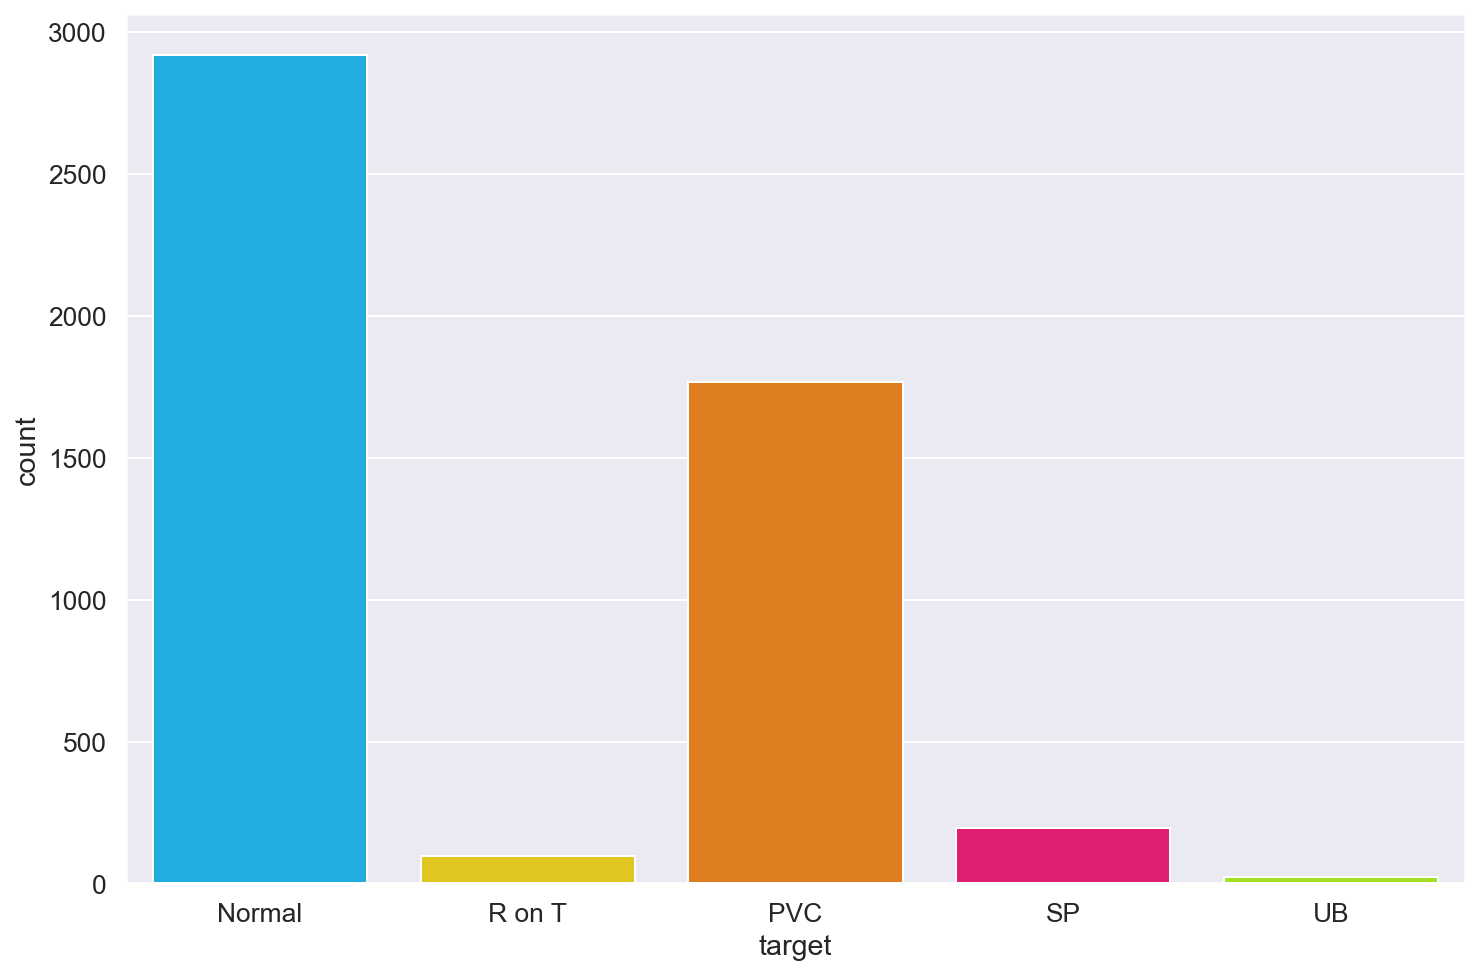

In [41]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

In [45]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

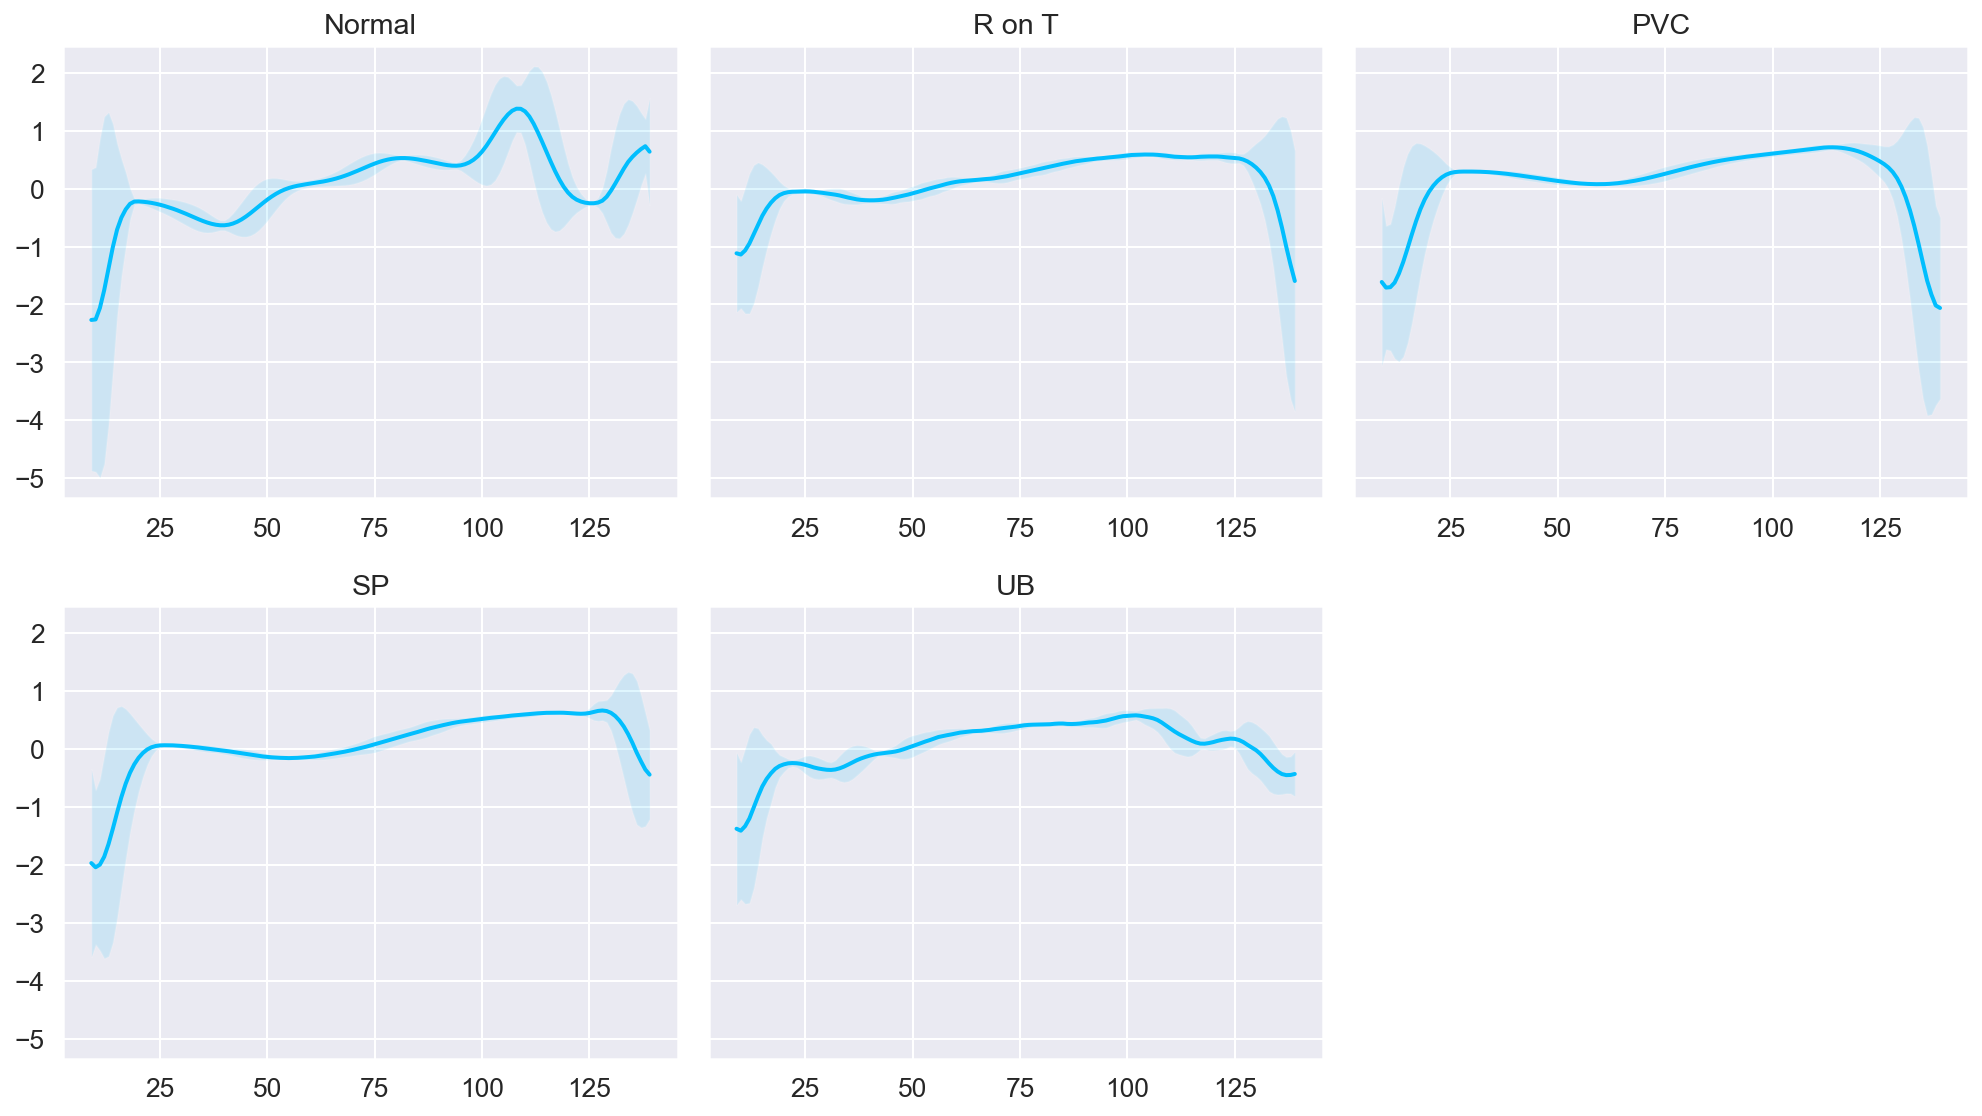

In [46]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

## Data Preparation

In [54]:
# put all normal ECG's in a dataframe and drop the label

df_norm = df[df.target == str(CLASS_NORMAL)].drop(labels = 'target', axis = 1)
df_norm.shape

(2919, 140)

In [55]:
# put all abnormal ECG's in a dataframe and drop the label

df_abnorm = df[df.target != str(CLASS_NORMAL)].drop(labels = 'target', axis = 1)
df_abnorm.shape

(2081, 140)

In [72]:
# Train Test Splits
# 

train, validate = train_test_split(df_norm, test_size=0.15, random_state = 42)

validate, test = train_test_split(validate, test_size=0.33, random_state = 42)


#### Converting dataframes to tensors

In [100]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [101]:
train_dataset, seq_len, n_features = create_dataset(train)
val_dataset, _, _ = create_dataset(validate)
test_normal_dataset, _, _ = create_dataset(test)
test_anomaly_dataset, _, _ = create_dataset(df_abnorm)